In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product, combinations, islice
# from geopy import distance
from copy import deepcopy
from random import choice
from tqdm.notebook import tqdm
import time

In [ ]:
# Latency matrix of shortest paths
def create_latency_matrix(graph):
    n = len(graph.nodes)
    latency_matrix = np.zeros((n,n), dtype=int)
    all_shortest_paths = [
        x[1] for x in nx.all_pairs_dijkstra_path_length(
            graph, weight='length'
        )
    ]
    for i,j in product(range(n),range(n)):
        latency_matrix[i][j] = all_shortest_paths[i][j]
    return latency_matrix

# Controller-Hypervisor-Switch latency matrix
def create_chs_latency_matrix(latency_matrix):
    n = latency_matrix.shape[0]
    chs_latency_matrix = np.zeros((n,n,n), dtype=int)
    for i,j,k in product(range(n),range(n),range(n)):
        chs_latency_matrix[i][j][k] = latency_matrix[i][j] + latency_matrix[j][k]
    return chs_latency_matrix

# Controllability matrix with given latency
def controllability_matrix(chs_latency_matrix, latency_contraint):
    return np.asarray(chs_latency_matrix <= latency_contraint, dtype=int)

#
def hypervisor_matrix(matrix, hypervisor):
    return matrix[:,hypervisor,:]

#
def controllability_hypervisor(cmatrix, hypervisor):
    return np.sum(hypervisor_matrix(cmatrix, hypervisor), axis=0)

In [ ]:
# Generating Graph
n = 20  # number of nodes
p = 0.2 # edge prob.
L = 3   # latency

while True:
    g = nx.generators.random_graphs.gnp_random_graph(n, p)
    if nx.is_connected(g):
        break

l_matrix = create_latency_matrix(g)
fl_matrix = create_chs_latency_matrix(l_matrix)
c_matrix = controllability_matrix(fl_matrix, L)

In [3]:
g = nx.read_gml('../data/raw/networks/italy.gml', label='id')
for edge in g.edges:
    g.edges[edge]['length'] = distance.distance(
        (g.nodes[edge[0]]['Latitude'], g.nodes[edge[0]]['Longitude']),
        (g.nodes[edge[1]]['Latitude'], g.nodes[edge[1]]['Longitude'])
    ).km

for node in g.nodes:
    g.nodes[node]['City'] = g.nodes[node]['label']
nx.write_gml(g, '../data/processed/networks/25_italy.gml')

In [3]:
g = nx.read_gml('../data/processed/networks/25_italy.gml', label='id')

V = list(g.nodes)
H = list(g.nodes)
C = list(g.nodes)

l_matrix = create_latency_matrix(g)
fl_matrix = create_chs_latency_matrix(l_matrix)

print(f"Longest shortest path in the network: {np.amax(l_matrix)}")
print(f"Minimum of maximal control latency: {np.amin(np.amax(fl_matrix, axis=2))}")

L = np.amax(l_matrix) / 2
print(f"Latency constraint: {L}")

c_matrix = controllability_matrix(fl_matrix, L)

Longest shortest path in the network: 1586
Minimum of maximal control latency: 805
Latency constraint: 793.0


In [5]:
g = nx.read_gml('../data/processed/networks/50_germany.gml', label='id')
for u,v in g.edges():
    print(f"{u} {v}")

0 29
0 48
0 46
1 47
1 34
1 49
2 31
2 8
2 37
3 31
3 11
3 43
3 32
3 20
4 35
4 44
4 22
4 5
5 32
5 21
5 22
5 25
6 38
6 7
6 22
7 15
8 11
8 13
9 16
9 33
9 23
10 14
10 35
10 44
10 25
11 31
11 13
12 14
12 29
13 31
13 25
13 49
14 48
15 27
16 28
16 19
16 18
17 24
17 30
18 25
18 19
18 49
19 44
19 25
20 43
21 43
21 27
21 22
22 39
23 28
23 42
23 24
24 33
24 42
24 45
26 30
26 34
27 43
28 29
28 44
28 46
30 45
31 32
32 43
34 40
34 37
34 41
35 39
36 48
36 38
37 49
37 41
38 48
38 39
40 41
42 46
45 47
45 49


In [ ]:
control_values = []
for latency_ratio in np.arange(0.1, 0.75, 0.04):
    L = np.amax(l_matrix) * latency_ratio
    c_matrix = controllability_matrix(fl_matrix, L)
    controlled_node_numbers = np.amax(np.sum(c_matrix, axis=2), axis=1)
    control_values.append(controlled_node_numbers)
    print(f"Latency ratio: {latency_ratio:.2f}\tMax controlled nodes: {np.amax(controlled_node_numbers)}")

control_values = np.asarray(control_values)

In [4]:
from src.data.graph_utilities import get_all_paths, construct_quartets

In [41]:
for k in [1,2,4,8,16,32,64]:
    t1 = time.perf_counter()
    all_paths = get_all_paths(g, max_length=4800, shortest_k=k)
    t_path = time.perf_counter() - t1
    t1 = time.perf_counter()
    Q, Qc, Qs = construct_quartets(C, V, H, all_paths, 4000)
    t_quartet = time.perf_counter() - t1
    print(f"{k}\t{t_path:.2f}\t{t_quartet:.2f}\t{len(Q)}")

1	0.08	1.31	36472
2	0.24	2.20	54941
4	0.65	4.11	65988
8	1.62	9.70	68712
16	3.73	33.75	69150
32	8.17	146.24	69194
64	18.42	499.53	69194


In [18]:
np.max([len(paths) for key,paths in all_paths.items()])

50

In [22]:
len(Q)

36472

In [207]:
"""Path-disjoint Set Cover"""
# path: set of tuples
# paths: list of path

def latency_of_path(G, p):
    length = 0
    for u,v in p:
        length += G[u][v]['length']
    return length


def k_shortest_paths(G, source, target, k, weight="length"):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )


def path_as_edges(path):
    if all(isinstance(x, int) for x in path):
        return set(zip(path[0::], path[1::]))
    elif all(isinstance(x, tuple) for x in path):
        return path
    else:
        raise TypeError


def get_paths(G, u, v, max_latency, shortest_k):
    shortest_k_path = k_shortest_paths(G, u, v, shortest_k)
    return list( path_as_edges(path) for path in shortest_k_path if latency_of_path(G, path_as_edges(path)) < max_latency)


def get_shortest_paths(G, u, v):
    return list(set(zip(path[0::], path[1::])) for path in nx.all_shortest_paths(G, u, v))


def is_disjoint(p, q):
    if isinstance(p, set) and isinstance(q, set):
        return p.isdisjoint(q)
    else:
        print(f"p: {isinstance(p, set)}\nq:{isinstance(q, set)}")
        p_ = set(p)
        q_ = set(q)
        return p_.isdisjoint(q_)


def is_path_disjoint(P, Q):
    for p,q in product(P,Q):
            if is_disjoint(p, q) and is_low_latency(p) and is_low_latency(q):
                return True
    return False

def is_low_latency(p):
    return len(p) < 2

def is_path_disjoint_cover(G, f, f_, c, max_latency):
    P = get_paths(G, f, c, max_latency, shortest_k=10)
    Q = get_paths(G, f_, c, max_latency, shortest_k=10)
    # P = list(set(zip(path[0::], path[1::])) for path in nx.all_shortest_paths(g, f, c))
    # Q = list(set(zip(path[0::], path[1::])) for path in nx.all_shortest_paths(g, f_, c))
    return is_path_disjoint(P, Q)


def construct_triplets(G, C, F, max_latency):
    T_self = set( (c,c,c) for c in C )
    T_not_self = set(
        (c, f, f_) for c,f,f_ in product(C,F,F)
        if (c != f) and (c != f_) and (f < f_) and is_path_disjoint_cover(G, f, f_, c, max_latency)
    )
    return T_self | T_not_self


def covered_customers(Tc, F, C):
    covered = []
    for c in C:
        if c in F:
            covered.append(c)
            continue
        for c, f, f_ in Tc[c]:
            if (f in F) and (f_ in F):
                covered.append(c)
                break
    return covered

def get_facility_for_maxcover(C, C_, F, F_, Tc, Tf):
    currently_covering = len(C_)
    F_notused = list( set(F) - set(F_) )

    covering = [len( covered_customers(Tc, list(F_) + [f], C) ) for f in F_notused]
    # max_index = covering.index(max(covering))
    max_covering = max(covering)
    max_indexes = [idx for idx, value in enumerate(covering) if value == max_covering]
    # print("Before: ", currently_covering, "Possible: ", sorted(covering, reverse=True)[:5])
    if max_covering > currently_covering:
        return set( [ F_notused[choice(max_indexes)] ] )
    else:
        return None


def get_facility_pair_for_maxcover(C, C_, F, F_, Tc, Tf):
    currently_covering = len(C_)
    F_notused = list(combinations( list(set(F)-set(F_)), 2))

    covering = [len( covered_customers(Tc, list(F_) + [f, f_], C) ) for f, f_ in F_notused]
    # max_index = covering.index(max(covering))
    max_covering = max(covering)
    max_indexes = [idx for idx, value in enumerate(covering) if value == max_covering]
    # print("Before: ", currently_covering, "Possible: ", sorted(covering, reverse=True)[:5])
    if max_covering > currently_covering:
        return set( F_notused[choice(max_indexes)] )
    else:
        return None


def minimize_cover(C, C_, F_, Tc):
    F_min = deepcopy(F_)
    for f in F_:
        if len( covered_customers(Tc, F_min - set([f]), C) ) == len(C_):
            # print("Minimized")
            F_min.discard(f)
    return F_min


def greedy(C, F, Tc, Tf):
    F_ = set()
    C_ = set()
    F_.update(get_facility_pair_for_maxcover(C, C_, F, F_, Tc, Tf))
    while C != C_:
        F_.update(get_facility_for_maxcover(C, C_, F, F_, Tc, Tf))
        # print("Step 1:  ", F_)
        C_ = covered_customers(Tc, F_, C)
        F_ = minimize_cover(C, C_, F_, Tc)
        # print("Step 2:  ", F_)
        # print("Covered: ", len(C_))
    return F_

In [191]:
T = construct_triplets(g, V, H, max_latency=1000)

Tf = {}
Tc = {}

for c, f, f_ in T:
    if f in H:
        Tf.setdefault(f, []).append((c,f,f_))
    if c in V:
        Tc.setdefault(c, []).append((c,f,f_))


CPU times: user 1.6 s, sys: 7.92 ms, total: 1.6 s
Wall time: 1.61 s


<AxesSubplot:ylabel='count'>

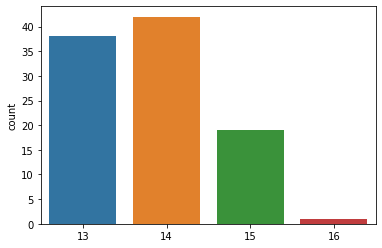

In [208]:
%time sns.countplot(x=[len(greedy(V, H, Tc, Tf)) for i in range(100)])

In [130]:
get_facility_pair_for_maxcover(V, set(), H, set(), Tc, Tf)

(2, 20)